# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [1]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from scipy.signal import convolve2d

# Useful functions 
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int64(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

def imagePad(I,h):
    res = np.zeros((I.shape[0]+ h - 1, I.shape[1] + h - 1))
    for i in range((h//2),(h//2) + I.shape[0]):
        for j in range((h//2),(h//2) + I.shape[1]):
            res[i,j] = I[i-(h//2),j-(h//2)]
    return res
def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [5]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    Sx = np.array([ [1, 0, -1], 
                    [2, 0, -2], 
                    [1, 0, -1]])

    Sy = np.array([[ 1,  2,  1], 
                   [ 0,  0,  0], 
                   [-1, -2, -1]])
    
    
    # la fonction convolved2d effectue la rotation
    """
    Qx = np.rot90(np.rot90(Sx))
    Qy = np.rot90(np.rot90(Sy))
    """
    
    # directionnal derivate 𝐼𝑥 and 𝐼𝑦
    
    Ix = convolve2d(image, Sx, 'same')
    Iy = convolve2d(image, Sy, 'same')
    
    # products 𝐼2𝑥, 𝐼2𝑦, 𝐼𝑥.𝐼𝑦
    
    IxPow2 = Ix**2
    IyPow2 = Iy**2
    IxIy = Ix*Iy
    
    # convolution of 𝐼2𝑥,𝐼2𝑦 and 𝐼𝑥.𝐼𝑦 by a gaussian kernel of size N
    N = scale//3 + 1
    gaussKern = gaussianKernel(N)
    
    M = np.array([convolve2d(IxPow2, gaussKern, 'same'),
                  convolve2d(IxIy, gaussKern, 'same'),
                  convolve2d(IxIy, gaussKern, 'same'),
                  convolve2d(IyPow2, gaussKern, 'same')])
    
    # Computation of  det(𝑀(𝑥,𝑦))  and  trace(𝑀(𝑥,𝑦))  for each pixel
    
    MDet = M[0]*M[3] - M[1]*M[2]
    MTrace = M[0] + M[3]
    
    # Computation of  𝑅(𝑥,𝑦)=det(𝑀(𝑥,𝑦))−𝑘.(trace(𝑀(𝑥,𝑦)))2
            
    R = MDet - kappa * MTrace ** 2
    return R    

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

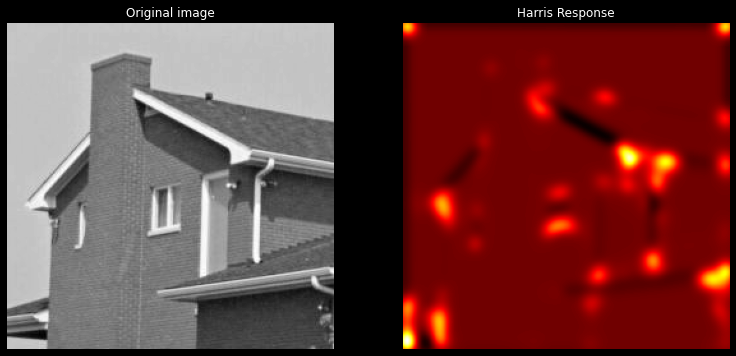

In [12]:
house2 = np.array(Image.open('img/house2.png'))
fig, axes = plt.subplots(1, 2, figsize=(13, 6))
axes[0].imshow(house2, cmap='gray')
axes[0].set_title('Original image')

R = computeR(house2, 15, 0.04)

axes[1].imshow(R, cmap='hot')
axes[1].set_title('Harris Response')

for ax in axes:
    ax.axis('off')

plt.show()

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

**On peux voir que notre résultat présente des zones de rouge, orange jaune et noire ( cmap 'hot' pour mettre en valeur les différentes zones) et des grandes zones grises homogènes. les zones grise sont les zones homogènes de l'image ou peu ou aucun contours n'est détécter. les zones jaune elles sont les contours les plus marquées de l'image ( ici le toit ) et les zones rouge sont les zones de rencontre de plusieurs bordures, les coins que nous cherchons à isolé.**

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

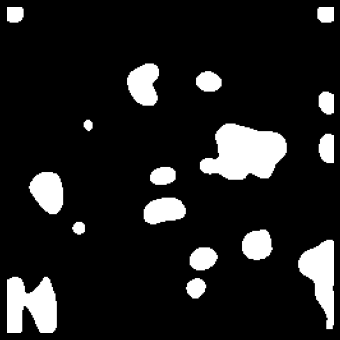

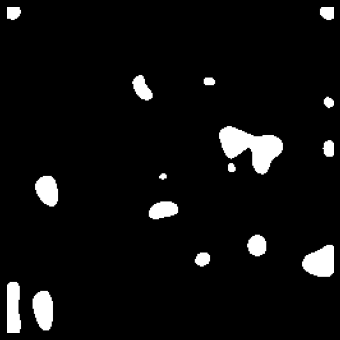

In [16]:
def normalize(I):
    return 255 *(I /np.max(I))


def thresholdR(R, thresh):
    """ 
    Array[n, m] * float -> Array[n, m]
    """
    n, m = R.shape
    threshImage = np.vectorize(lambda x: 255 if x > thresh else 0)(R)
    return threshImage

imshow(thresholdR(R, 55550000))
imshow(thresholdR(normalize(R), 50))
# il semble plus pratique de normaliser l'image pour mieux jouer sur le filtre

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [30]:
#Version non optimisée
"""
    def rnms(R, Rbin):
    n, m = R.shape
    PadR = imagePad(R, 3)
    RLocMax = np.zeros((n, m))
    for x in range(n):
        for y in range(m):
            if(Rbin[x, y] == 1):
                if(R[x, y] == np.max(PadR[(x):(x + 3), (y):(y + 3)])):
                    RLocMax[x, y] = 1
    
    return RLocMax
    """

#Version optimisée
def rnms(R, Rbin):
    """ Array[n, m] -> Array[n, m] """
    n, m = R.shape
    PadR = imagePad(R, 3)
    RLocMax = np.zeros((n, m))
    # On récupère les indices des pixels qui ont des valeur différente de 0
    nonzeros = np.nonzero(Rbin)

    # Puis on les parcours
    for x, y in zip(nonzeros[0], nonzeros[1]):
        # On récupère le maximum de la matrice 3x3 ( voisinage du pixel que l'on traite )
        # Comme on regarde sur les indices de Rbin, on doit décaler les indices quand on regarde sur PadR ( donc pas de -1 )
        if(R[x, y] == np.max(PadR[x:x + 3, y:y + 3])):
            RLocMax[x, y] = 1

    return RLocMax

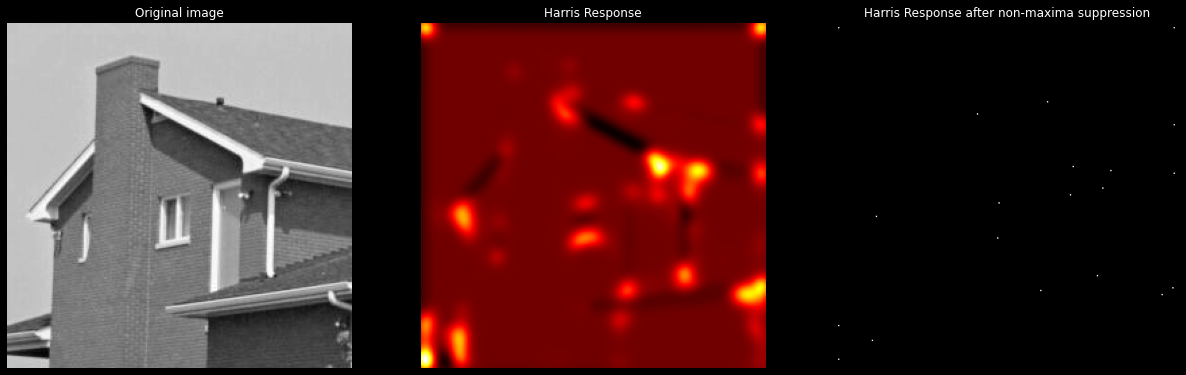

In [31]:

fig, axes = plt.subplots(1, 3, figsize=(21, 7))
axes[0].imshow(house2, cmap='gray')
axes[0].set_title('Original image')

R = computeR(house2, 15, 0.04)
Rbin = thresholdR(normalize(R), 50)

axes[1].imshow(R, cmap='hot')
axes[1].set_title('Harris Response')

axes[2].imshow(rnms(R, Rbin), cmap='gray')
axes[2].set_title('Harris Response after non-maxima suppression')

for ax in axes:
    ax.axis('off')

plt.show()

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

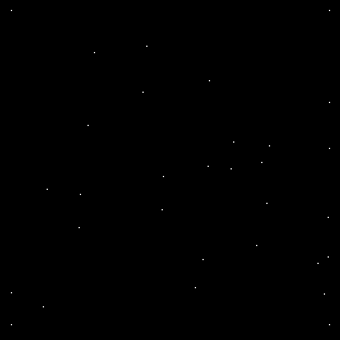

In [33]:
def cornerDetector(image, scale, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    R = computeR(image, scale, kappa)
    ThreshR = thresholdR(normalize(R),thres)
    return rnms(R,ThreshR)
    
CornerHouse = cornerDetector(house2, 15, 0.04, 12)
imshow(CornerHouse)

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

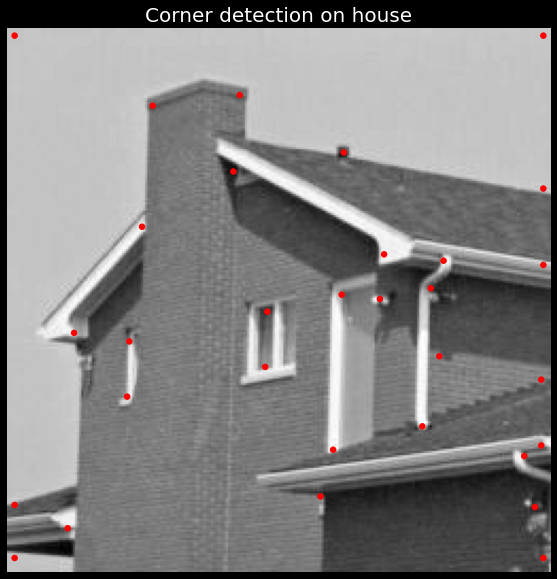

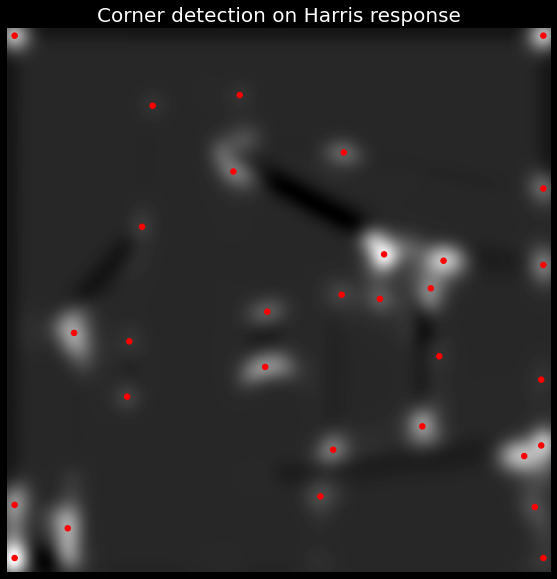

In [91]:
def RedDisk(I, ICorner, title=None):
    corners =(np.nonzero(ICorner))
    plt.figure(figsize=(10, 10))
    plt.imshow(I, cmap='gray')
    plt.scatter(x=corners[1], y=corners[0], s=np.ones(corners[0].shape[0])*30, c="red")
    plt.axis('off')
    if title is not None: plt.title(title, fontsize=20)
    plt.show()


CornerHouse = cornerDetector(house2, 15, 0.04, 12)
RedDisk(house2, CornerHouse, "Corner detection on house")
RedDisk(R, CornerHouse, "Corner detection on Harris response")

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

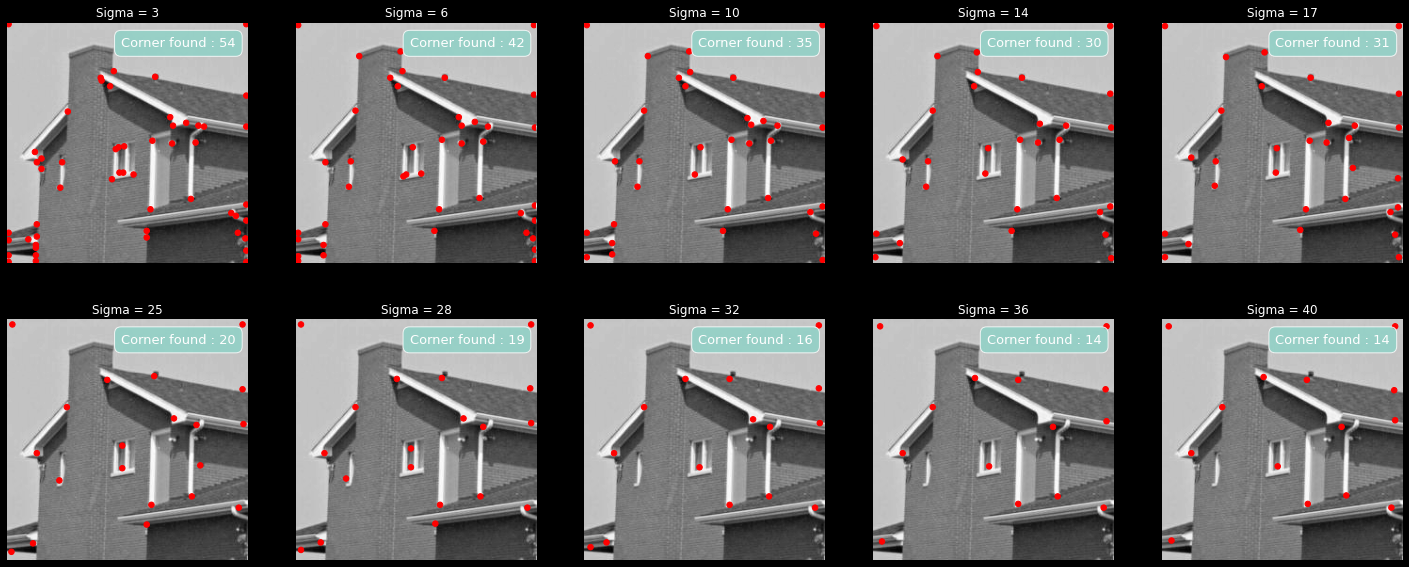

In [59]:
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
sigma = np.linspace(3,40,11,dtype=int)
taille_cercle = 30

for i, sig1, sig2 in zip(range(5),sigma[:5], sigma[6:]):
    axes[0,i].imshow(house2, cmap='gray')
    Corner = np.nonzero(cornerDetector(house2, sig1, 0.04, 12))
    axes[0,i].scatter(x=Corner[1], y=Corner[0], s=np.ones(Corner[0].shape)*taille_cercle, c="red")
    axes[0,i].set_title('Sigma = ' + str(sig1))
    axes[0,i].axis('off')
    axes[0,i].text(0.95, 0.90, 'Corner found : ' + str(Corner[0].shape[0]), fontsize=13, transform=axes[0,i].transAxes, \
        horizontalalignment='right', bbox=dict(alpha=0.8, boxstyle='round',pad=0.5))

    axes[1,i].imshow(house2, cmap='gray')
    Corner = np.nonzero(cornerDetector(house2, sig2, 0.04, 12))
    axes[1,i].scatter(x=Corner[1], y=Corner[0], s=np.ones(Corner[0].shape)*taille_cercle, c="red")
    axes[1,i].set_title('Sigma = ' + str(sig2))
    axes[1,i].axis('off')
    axes[1,i].text(0.95, 0.90, 'Corner found : ' + str(Corner[0].shape[0]), fontsize=13, transform=axes[1,i].transAxes, \
        horizontalalignment='right', bbox=dict(alpha=0.8, boxstyle='round',pad=0.5))

plt.show()

# **Interprétation :**
**On vois que plus Sigma est faible plus on retrouve des petit cluster de points rouge, la ou les 
coins sont detectés. Le Sigma permet donc de calibrer la taille des zones suceptible de contenir 
nos coins.** 

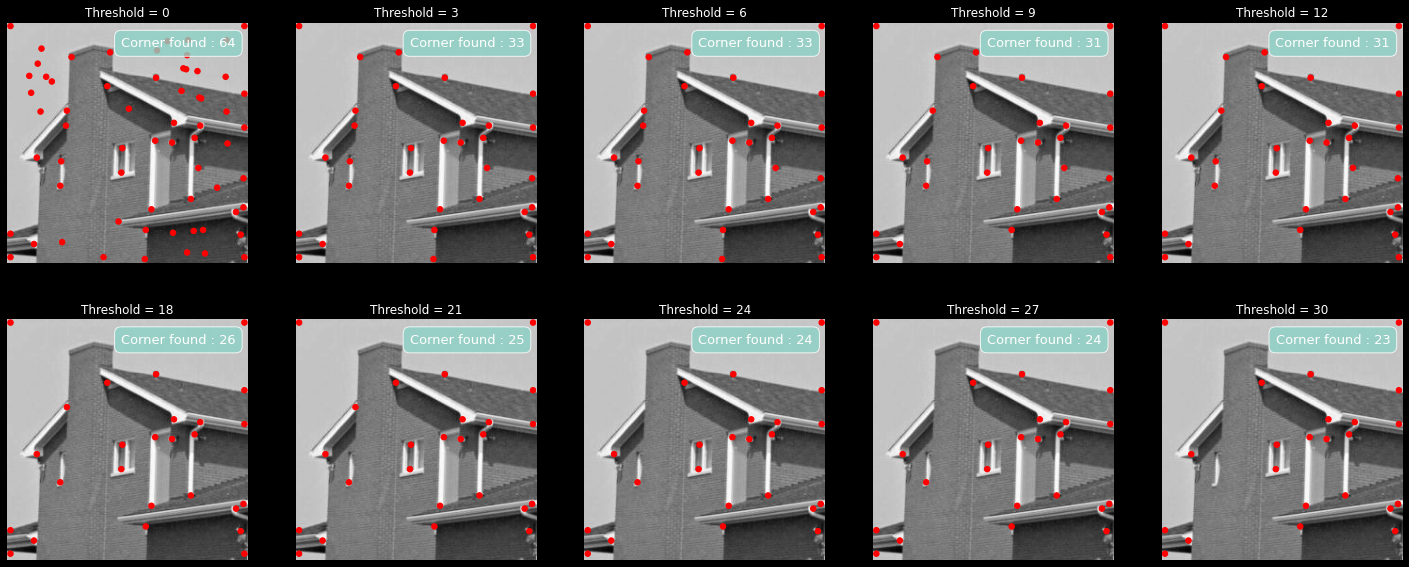

In [62]:
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
threshold = np.linspace(0,30,11,dtype=int)
taille_cercle = 30

for i, thresh1, thresh2 in zip(range(5),threshold[:5], threshold[6:]):
    axes[0,i].imshow(house2, cmap='gray')
    Corner = np.nonzero(cornerDetector(house2, 15, 0.04, thresh1))
    axes[0,i].scatter(x=Corner[1], y=Corner[0], s=np.ones(Corner[0].shape)*taille_cercle, c="red")
    axes[0,i].set_title('Threshold = ' + str(thresh1))
    axes[0,i].axis('off')
    axes[0,i].text(0.95, 0.90, 'Corner found : ' + str(Corner[0].shape[0]), fontsize=13, transform=axes[0,i].transAxes, \
        horizontalalignment='right', bbox=dict(alpha=0.8, boxstyle='round',pad=0.5))

    axes[1,i].imshow(house2, cmap='gray')
    Corner = np.nonzero(cornerDetector(house2, 15, 0.04, thresh2))
    axes[1,i].scatter(x=Corner[1], y=Corner[0], s=np.ones(Corner[0].shape)*taille_cercle, c="red")
    axes[1,i].set_title('Threshold = ' + str(thresh2))
    axes[1,i].axis('off')
    axes[1,i].text(0.95, 0.90, 'Corner found : ' + str(Corner[0].shape[0]), fontsize=13, transform=axes[1,i].transAxes, \
        horizontalalignment='right', bbox=dict(alpha=0.8, boxstyle='round',pad=0.5))

plt.show()

# **Interprétation :**
**Treshold lui permet d'effectuer un travail de filtrage des points parasites mais n'a pas besoin 
de trop varier pour etre efficace ( la valeur de seuil 0 est particulière).**

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

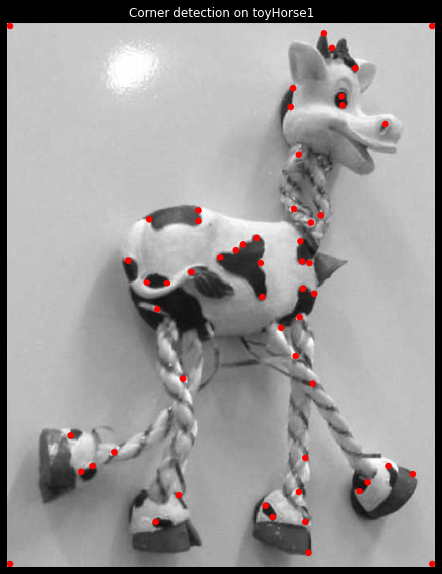

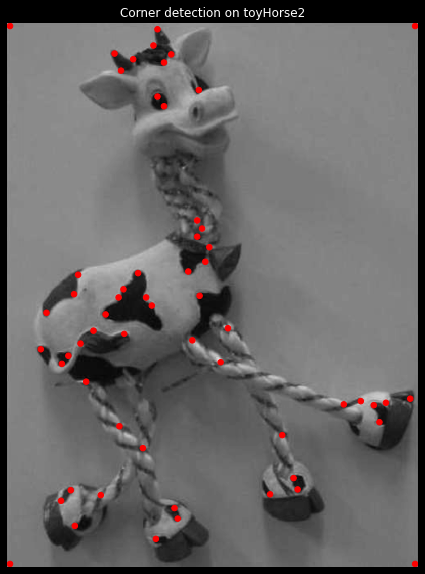

In [66]:
toy1 = np.array(Image.open('img/toyHorse1.png'))
toy2 = np.array(Image.open('img/toyHorse2.png'))

# ToyHorse1
CornerToy1 = cornerDetector(toy1, 15, 0.04, 20)
RedDisk(toy1, CornerToy1, "Corner detection on toyHorse1")

# ToyHorse2
CornerToy2 = cornerDetector(toy2, 15, 0.04, 20)
RedDisk(toy2, CornerToy2, "Corner detection on toyHorse2")

2) What are the dynamic ranges of these two images ?

In [65]:
print(f"dynamic range (toy1) :[{str(toy1.min())}, {str(toy1.max())}]")
print(f"dynamic range (toy2) :[{str(toy2.min())}, {str(toy2.max())}]")

dynamic range (toy1) :[1, 255]
dynamic range (toy2) :[0, 253]


3) What are the transformations beetween the two images ?

**On peux voir que les deux image représente toute deux le même jouet dans la même position mais avec un luminositée et un angle de vue différent. Malgré ces différences, les points clé sont bien repérés comme les yeux, les taches, les jambes, le coup, et les cornes ( en revanche les oreilles ne sont pas bien détourés). On pourrais peux être utiliser ces points pour de la reconstruction 3D.**

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

In [85]:
def rotateImage(I,a):
    """ Array*float -> Array 
        return a rotation of angle a (degree) of image I
    """
    return np.array(Image.fromarray(I).rotate(a, expand=True, fillcolor=127))

def transfBrightness(I:np.array,b):
    """ Array*float -> Array 
        return a more or less brighter image of image I
    """
    if(b<-255 or b>255):
        raise ValueError("b must be between -255 and 255")
    return np.clip(I.astype(np.int16)+b,0,255)

(-0.5, 832.5, 832.5, -0.5)

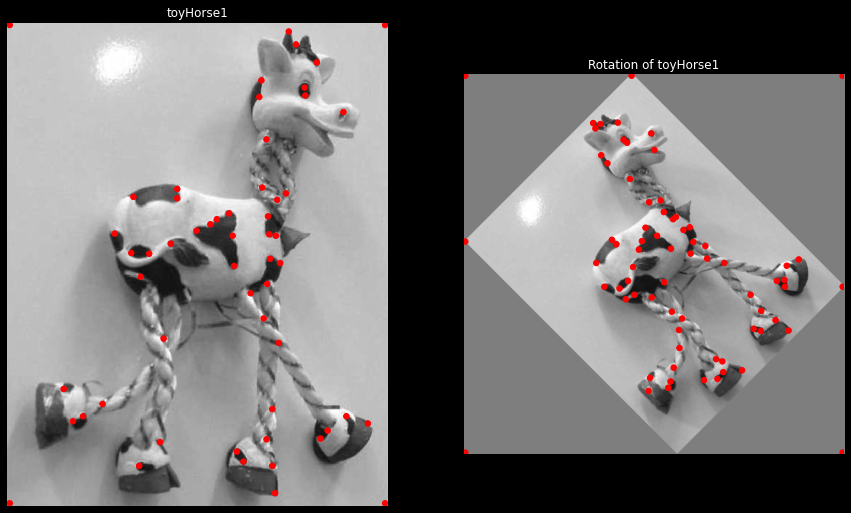

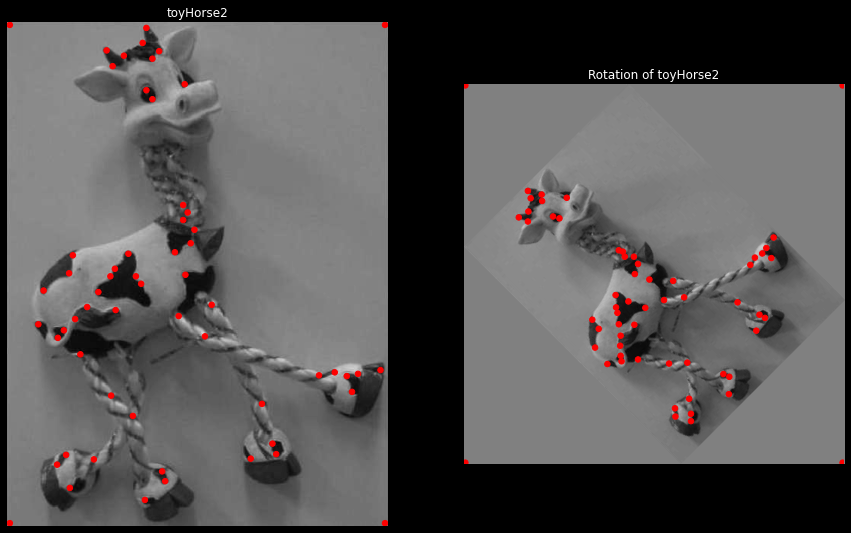

In [95]:
CornerToy1 = cornerDetector(toy1, 15, 0.04, 20)
corners =(np.nonzero(CornerToy1))

fig = plt.figure(figsize=(15, 15))

plt.subplot(1,2,1)
plt.imshow(toy1, cmap='gray')
plt.scatter(x=corners[1], y=corners[0], s=np.ones(corners[0].shape)*30, c="red")
plt.title('toyHorse1')
plt.axis('off')

rotateToy1 = rotateImage(toy1,45)
CornerToy1 = cornerDetector(rotateToy1, 15, 0.04, 20)
corners =(np.nonzero(CornerToy1))


plt.subplot(1,2,2)
plt.imshow(rotateToy1, cmap='gray')
plt.scatter(x=corners[1], y=corners[0], s=np.ones(corners[0].shape)*30, c="red")
plt.title('Rotation of toyHorse1')
plt.axis('off')

CornerToy2 = cornerDetector(toy2, 15, 0.04, 20)
corners =(np.nonzero(CornerToy2))

fig = plt.figure(figsize=(15, 15))

plt.subplot(1,2,1)
plt.imshow(toy2, cmap='gray')
plt.scatter(x=corners[1], y=corners[0], s=np.ones(corners[0].shape)*30, c="red")
plt.title('toyHorse2')
plt.axis('off')

rotateToy2 = rotateImage(toy2,45)
CornerToy2 = cornerDetector(rotateToy2, 15, 0.04, 20)
corners =(np.nonzero(CornerToy2))


plt.subplot(1,2,2)
plt.imshow(rotateToy2, cmap='gray')
plt.scatter(x=corners[1], y=corners[0], s=np.ones(corners[0].shape)*30, c="red")
plt.title('Rotation of toyHorse2')
plt.axis('off')

# **Interprétation :**
**On vois que la rotation ne semble pas avoir affecter la détéction de coins.**

In [ ]:
BriToy1 = transfBrightness(toy1,100)
CornerToy1 = cornerDetector(BriToy1, 15, 0.04, 20)
RedDisk(BriToy1, CornerToy1)
BriToy2 = transfBrightness(toy2,-60)
CornerToy2 = cornerDetector(BriToy2, 15, 0.04, 20)
RedDisk(BriToy2, CornerToy2)

# **Interprétation :**
**On vois que la transformation affine de luminosité n'a pas affecté la détéction de coins.**